# Quantum Repeater Design - Purification Optimization Test


In [20]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import IBMQ, transpile, execute
from qiskit.result import Counts, marginal_counts
from qiskit.visualization import array_to_latex, plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector, Statevector, state_fidelity, DensityMatrix
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator, AerSimulator
from qiskit.circuit import Instruction, Gate
from qiskit.circuit.library import RXGate
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.quantum_info.analysis import hellinger_fidelity

In [21]:
def get_device_noise_model() -> (AerSimulator, NoiseModel):
    provider = IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')

    backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                       not b.configuration().simulator and b.status().operational==True))
    backend = AerSimulator.from_backend(backend)

    noise_model = NoiseModel.from_backend(backend)
    return backend, noise_model

In [22]:
SHOTS = 4096
ITERATIONS_TO_AVG = 20
backend, noise_model = get_device_noise_model()

ibmqfactory.load_account:WARNING:2023-02-28 22:55:05,231: Credentials are already in use. The existing account in the session will be replaced.


In [23]:
print("Backend:\n", backend)
print("\nNoise Model:\n", noise_model)

Backend:
 aer_simulator(ibmq_belem)

Noise Model:
 NoiseModel:
  Basis gates: ['cx', 'for_loop', 'id', 'if_else', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'superop', 'sx', 'while_loop', 'x']
  Instructions with noise: ['reset', 'id', 'cx', 'x', 'measure', 'sx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), 

In [24]:
class QuantumCircuitOperations:
    def __init__(self, barrier: bool = False):
        self.barrier = barrier
    
    def create_random_statevector(self, dimensions: int) -> Statevector:
        return random_statevector(dimensions)
    
    def create_bell_pairs(self, qc: QuantumCircuit, regs: list) -> None:
        if self.barrier: qc.barrier()
        for reg in regs:
            for q in range(reg.size):
                if q % 2 == 0:
                    qc.h(reg[q])
                    qc.cx(reg[q], reg[q + 1])
    
    def bell_state_operation(self, qc: QuantumCircuit, a: list = [QuantumRegister, QuantumRegister]) -> None:
        if self.barrier: qc.barrier()
        qc.cx(a[0], a[1])
        qc.h(a[0])
    
    def bell_state_measurement(self, qc: QuantumCircuit, a: list = [QuantumRegister, QuantumRegister]) -> None:
        if self.barrier: qc.barrier()
        qc.measure(a[0], 0)
        qc.measure(a[1], 1)
    
    def pauli_correction_operation(self, qc: QuantumCircuit, b: QuantumRegister, bsm_z: ClassicalRegister, bsm_x: ClassicalRegister) -> None:
        # Apply the gates if the registers are in the state '1'
        if self.barrier: qc.barrier()
        qc.x(b).c_if(bsm_x, 1)
        qc.z(b).c_if(bsm_z, 1)

In [25]:
class QuantumVisualizations:
    def display_statevector_as_array(self, psi: Statevector) -> None:
        display(array_to_latex(psi, prefix="|\\psi\\rangle = "))
    
    def display_bloch_statevector(self, psi: Statevector):
        return plot_bloch_multivector(psi)

In [26]:
class QuantumNativeSimulations:
    def statevector_sim(self, qc: QuantumCircuit) -> Statevector:
        # returns the circuit statevector
        state_sim: StatevectorSimulator = StatevectorSimulator()
        return state_sim.run(transpile(qc, state_sim)).result().get_statevector()
    
    def qasm_sim(self, qc: QuantumCircuit, optimization: int) -> Counts:
        qasm_sim: QasmSimulator = QasmSimulator()
        # result = execute(qc, qasm_sim, shots=10240, optimization_level=optimization).result()
        result = execute(qc, qasm_sim, shots=SHOTS, optimization_level=optimization,noise_model=noise_model).result()
        return result.get_counts()
        # return qasm_sim.run(transpile(qc, qasm_sim), shots=10240).result().get_counts()

In [27]:
def get_count_from_duplicate_circuit(c: QuantumCircuit, a: QuantumRegister, b: QuantumRegister, optimization: int) -> (QuantumCircuit,Counts):
    qcn: QuantumCircuit = c.copy(name="qcn")
    qcn.barrier()
    qcn.measure(a, 0)
    qcn.measure(b, 1)
    qcn_counts: Counts = qns.qasm_sim(qcn, optimization)
    return (qcn, qcn_counts)

In [28]:
def get_fidelities_dict(dc: dict) -> dict:
    # compare fidelities
    dictlen: int = len(dc)
    dict_fids = {}

    for i in range(dictlen):
        if i == dictlen - 1:
            break
        cur: str = list(dc.keys())[0]
        nxt: str = list(dc.keys())[i + 1]
        fidelity: float = hellinger_fidelity(dc[cur], dc[nxt])
        f = "F("+cur+","+nxt+")"
        dict_fids[f] = fidelity
    return dict_fids

In [29]:
# Deutsch Purification
def full_deutsch_purification() -> Gate:
    c = QuantumCircuit(6, name="Full Deutsch")
    c.append(RXGate(np.pi/2), [0])
    c.append(RXGate(-np.pi/2), [4])
    c.append(RXGate(np.pi/2), [2])
    c.append(RXGate(-np.pi/2), [3])
    c.append(RXGate(-np.pi/2), [1])
    c.append(RXGate(np.pi/2), [5])

    c.cx(0, 2)
    c.cx(0, 4)

    c.cx(1, 5)
    c.cx(1, 3)
    c.to_gate(label="Full Deutsch")
    return c

def quad_deutsch_purification(n: int) -> Gate:
    c = QuantumCircuit(n, name="Quad Deutsch")
    c.append(RXGate(np.pi/2), [0])
    c.append(RXGate(-np.pi/2), [1])
    c.append(RXGate(np.pi/2), [2])
    c.append(RXGate(-np.pi/2), [3])
    
    c.cx(0, 2)
    c.cx(1, 3)
    
    c.to_gate(label="Quad Deutsch")
    return c

def duo_deutsch_purification(n: int) -> Gate:
    c = QuantumCircuit(n, name="Duo Deutsch")
    c.append(RXGate(np.pi/2), [0])
    c.append(RXGate(-np.pi/2), [1])
    
    c.to_gate(label="Duo Deutsch")
    return c


# Bennett's Purification
def full_bennett_purification() -> Gate:
    c = QuantumCircuit(6, name="Full Bennett")
    c.append(RXGate(np.pi/2), [0])
    c.append(RXGate(-np.pi/2), [4])
    c.append(RXGate(np.pi/2), [2])
    c.append(RXGate(-np.pi/2), [3])
    c.append(RXGate(-np.pi/2), [1])
    c.append(RXGate(np.pi/2), [5])

    c.cx(0, 2)
    c.cx(0, 4)

    c.cx(1, 5)
    c.cx(1, 3)
    c.to_gate(label="Full Bennett")
    return c

def quad_bennett_purification(n: int) -> Gate:
    c = QuantumCircuit(n, name="Quad Bennett")
    c.append(RXGate(np.pi/2), [0])
    c.append(RXGate(-np.pi/2), [1])
    c.append(RXGate(np.pi/2), [2])
    c.append(RXGate(-np.pi/2), [3])
    
    c.cx(0, 2)
    c.cx(1, 3)
    
    c.to_gate(label="Quad Bennett")
    return c

def duo_bennett_purification(n: int) -> Gate:
    c = QuantumCircuit(n, name="Duo Bennett")
    c.append(RXGate(np.pi/2), [0])
    c.append(RXGate(-np.pi/2), [1])
    
    c.to_gate(label="Duo Bennett")
    return c

In [30]:
qco: QuantumCircuitOperations = QuantumCircuitOperations(True)
qns: QuantumNativeSimulations = QuantumNativeSimulations()
qv: QuantumVisualizations = QuantumVisualizations()

dict_counts: dict= {}

In [31]:
def deutsch_fidelity_analysis(strategy: str = None, optimization: int = 1) -> (QuantumCircuit, Counts) :
    alice: QuantumRegister = QuantumRegister(2, "alice")
    charlie: QuantumRegister = QuantumRegister(2, "charlie")
    bob: QuantumRegister = QuantumRegister(2, "bob")

    bsm_z: ClassicalRegister = ClassicalRegister(1, "bsm_zresult")
    bsm_x: ClassicalRegister = ClassicalRegister(1, "bsm_xresult")

    coz: ClassicalRegister = ClassicalRegister(1, "coz")
    cox: ClassicalRegister = ClassicalRegister(1, "cox")

    qc: QuantumCircuit = QuantumCircuit(alice, charlie, bob, bsm_z, bsm_x)#, coz, cox)
    
    dict_counts.clear()
    
    psi: Statevector = qco.create_random_statevector(2)
    init_instruction: Initialize = Initialize(psi)
    init_instruction.label = "init instruction"
    qc.append(init_instruction, [alice[0]])
    # qc.append(init_instruction, [bob[1]])
    
    qco.create_bell_pairs(qc, [alice, charlie, bob])
    # purification after bell pair creation
    if strategy == "abpc" or strategy == "cust":
        qc.append( quad_deutsch_purification(4), [alice[0], alice[1], charlie[0], charlie[1]] )
    # count after bell pair creation
    qc_abpc, count_abpc = get_count_from_duplicate_circuit(qc, alice[0], alice[1], optimization)
    dict_counts["abpc"] = count_abpc
    
    # count after entanglement after distribution/transmission
    qc_dist, count_dist = get_count_from_duplicate_circuit(qc, alice[0], alice[1], optimization)
    dict_counts["dist"] = count_dist
    
    # Swap Protocol Stage 1
    if strategy == "swapalt":
        qc.append( quad_deutsch_purification(4), [alice[0], alice[1], charlie[0], charlie[1]] )
    qco.bell_state_operation(qc, [alice[1], charlie[0]])
    qco.bell_state_measurement(qc, [alice[1], charlie[0]])
    qco.pauli_correction_operation(qc, charlie[1], bsm_z, bsm_x)
    # purification after first swap protocol
    if strategy == "aswap1" or strategy == "swap" or strategy == "swapalt" or strategy == "cust":
        qc.append( quad_deutsch_purification(4), [alice[0], charlie[1], bob[0], bob[1]] )
        
    if strategy == "swaploop":
        for i in range(3):
            qc.append( quad_deutsch_purification(4), [alice[0], charlie[1], bob[0], bob[1]] )
        
    # count after first stage swap
    qc_aswap, count_aswap = get_count_from_duplicate_circuit(qc, alice[0], charlie[1], optimization)
    dict_counts["aswap1"] = count_aswap

    # Swap Protocol Stage 2
    if strategy == "swapalt":
        qc.append( quad_deutsch_purification(4), [alice[0], charlie[1], bob[0], bob[1]] )
    qco.bell_state_operation(qc, [charlie[1], bob[0]])
    qco.bell_state_measurement(qc, [charlie[1], bob[0]])
    qco.pauli_correction_operation(qc, bob[1], bsm_z, bsm_x)
    # purification after second swap protocol
    if strategy == "aswap2" or strategy == "swap" or strategy == "swapalt" or strategy == "cust":
        qc.append( duo_deutsch_purification(2), [alice[0], bob[1]] )
        
    if strategy == "swaploop":
        for i in range(3):
            qc.append( duo_deutsch_purification(2), [alice[0], bob[1]] )
        
    # count after second stage swap
    qc_aswap, count_aswap = get_count_from_duplicate_circuit(qc, alice[0], bob[1], optimization)
    dict_counts["aswap2"] = count_aswap
    
    qc.barrier()
    qc.cx(alice[0], bob[1])
    qc.h(alice[0])
    
    # Inverse
    qc.barrier()
    inverse_init_instruction: Initialize = init_instruction.gates_to_uncompute()
    qc.append(inverse_init_instruction, [alice[0]])
    # qc.append(inverse_init_instruction, [bob[1]])
    
    qc.barrier()
    qc.measure(alice[0], bsm_z)#coz)
    qc.measure(bob[1], bsm_x)#cox)

    counts: Counts = qns.qasm_sim(qc, optimization)
    dict_counts["count_end"] = counts
    
    return (qc, counts)

In [32]:
def bennett_fidelity_analysis(strategy: str = None, optimization: int = 1) -> (QuantumCircuit, Counts) :
    alice: QuantumRegister = QuantumRegister(2, "alice")
    charlie: QuantumRegister = QuantumRegister(2, "charlie")
    bob: QuantumRegister = QuantumRegister(2, "bob")

    bsm_z: ClassicalRegister = ClassicalRegister(1, "bsm_zresult")
    bsm_x: ClassicalRegister = ClassicalRegister(1, "bsm_xresult")

    coz: ClassicalRegister = ClassicalRegister(1, "coz")
    cox: ClassicalRegister = ClassicalRegister(1, "cox")

    qc: QuantumCircuit = QuantumCircuit(alice, charlie, bob, bsm_z, bsm_x)#, coz, cox)
    
    dict_counts.clear()
    
    psi: Statevector = qco.create_random_statevector(2)
    init_instruction: Initialize = Initialize(psi)
    init_instruction.label = "init instruction"
    qc.append(init_instruction, [alice[0]])
    # qc.append(init_instruction, [bob[1]])
    
    qco.create_bell_pairs(qc, [alice, charlie, bob])
    # purification after bell pair creation
    if strategy == "abpc" or strategy == "cust":
        qc.append( quad_bennett_purification(4), [alice[0], alice[1], charlie[0], charlie[1]] )
    # count after bell pair creation
    qc_abpc, count_abpc = get_count_from_duplicate_circuit(qc, alice[0], alice[1], optimization)
    dict_counts["abpc"] = count_abpc
    
    # count after entanglement after distribution/transmission
    qc_dist, count_dist = get_count_from_duplicate_circuit(qc, alice[0], alice[1], optimization)
    dict_counts["dist"] = count_dist
    
    # Swap Protocol Stage 1
    if strategy == "swapalt":
        qc.append( quad_bennett_purification(4), [alice[0], alice[1], charlie[0], charlie[1]] )
    qco.bell_state_operation(qc, [alice[1], charlie[0]])
    qco.bell_state_measurement(qc, [alice[1], charlie[0]])
    qco.pauli_correction_operation(qc, charlie[1], bsm_z, bsm_x)
    # purification after first swap protocol
    if strategy == "aswap1" or strategy == "swap" or strategy == "swapalt" or strategy == "cust":
        qc.append( quad_bennett_purification(4), [alice[0], charlie[1], bob[0], bob[1]] )
        
    if strategy == "swaploop":
        for i in range(3):
            qc.append( quad_bennett_purification(4), [alice[0], charlie[1], bob[0], bob[1]] )
        
    # count after first stage swap
    qc_aswap, count_aswap = get_count_from_duplicate_circuit(qc, alice[0], charlie[1], optimization)
    dict_counts["aswap1"] = count_aswap

    # Swap Protocol Stage 2
    if strategy == "swapalt":
        qc.append( quad_bennett_purification(4), [alice[0], charlie[1], bob[0], bob[1]] )
    qco.bell_state_operation(qc, [charlie[1], bob[0]])
    qco.bell_state_measurement(qc, [charlie[1], bob[0]])
    qco.pauli_correction_operation(qc, bob[1], bsm_z, bsm_x)
    # purification after second swap protocol
    if strategy == "aswap2" or strategy == "swap" or strategy == "swapalt" or strategy == "cust":
        qc.append( duo_bennett_purification(2), [alice[0], bob[1]] )
        
    if strategy == "swaploop":
        for i in range(3):
            qc.append( duo_bennett_purification(2), [alice[0], bob[1]] )
        
    # count after second stage swap
    qc_aswap, count_aswap = get_count_from_duplicate_circuit(qc, alice[0], bob[1], optimization)
    dict_counts["aswap2"] = count_aswap
    
    qc.barrier()
    qc.cx(alice[0], bob[1])
    qc.h(alice[0])
    
    # Inverse
    qc.barrier()
    inverse_init_instruction: Initialize = init_instruction.gates_to_uncompute()
    qc.append(inverse_init_instruction, [alice[0]])
    # qc.append(inverse_init_instruction, [bob[1]])
    
    qc.barrier()
    qc.measure(alice[0], bsm_z)#coz)
    qc.measure(bob[1], bsm_x)#cox)

    counts: Counts = qns.qasm_sim(qc, optimization)
    dict_counts["count_end"] = counts
    
    return (qc, counts)

### With Purification After Bell-pair production - Post Bell-Pair production purification

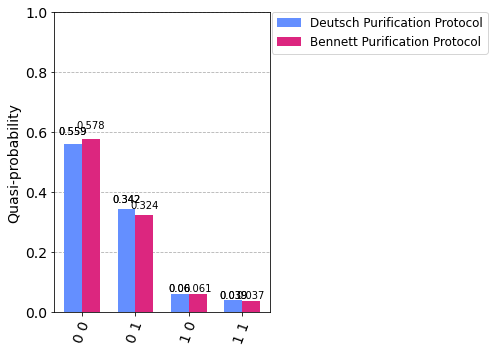

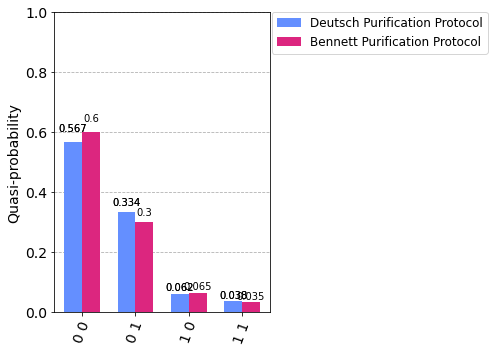

In [33]:
d1, b1 = [], []
d3, b3 = [], []
for i in range(ITERATIONS_TO_AVG):
    dcirc, dcounts1 = deutsch_fidelity_analysis("abpc", 1)
    bcirc, bcounts1 = bennett_fidelity_analysis("abpc", 1)
    dcirc, dcounts3 = deutsch_fidelity_analysis("abpc", 3)
    bcirc, bcounts3 = bennett_fidelity_analysis("abpc", 3)
    d1.append(dcounts1)
    b1.append(bcounts1)
    d3.append(dcounts3)
    b3.append(bcounts3)

dcounts1 = dict( pd.DataFrame(d1).mean() )
bcounts1 = dict( pd.DataFrame(b1).mean() )
dcounts3 = dict( pd.DataFrame(d3).mean() )
bcounts3 = dict( pd.DataFrame(b3).mean() )

ddict_fids_abpc: dict = get_fidelities_dict(dict_counts)
bdict_fids_abpc: dict = get_fidelities_dict(dict_counts)

ddict_fids_abpc: dict = get_fidelities_dict(dict_counts)
bdict_fids_abpc: dict = get_fidelities_dict(dict_counts)

dcounts1 = dict(sorted(dcounts1.items()))
bcounts1 = dict(sorted(bcounts1.items()))
dcounts3 = dict(sorted(dcounts3.items()))
bcounts3 = dict(sorted(bcounts3.items()))

dres1 = { key: abs( dcounts1[key] - bcounts1.get(key, 0) ) for key in dcounts1.keys() }
dres3 = { key: abs( dcounts3[key] - bcounts3.get(key, 0) ) for key in dcounts3.keys() }

legend = ["Deutsch Purification Protocol", "Bennett Purification Protocol"]
d = plot_histogram([dcounts1, bcounts1], legend=legend)#, title="Testing Purification Protocols Under Light Optimization Scheme")
b = plot_histogram([dcounts3, bcounts3], legend=legend)#, title="Testing Purification Protocols Under Heavier Optimization Scheme")

dx = d.axes[0]
bx = b.axes[0]
dx.set_ylim(0, 1)
bx.set_ylim(0, 1)

display(d, b)


In [34]:
d.savefig("po_post_bell_pair_light_opt_test.jpg", dpi=500)
b.savefig("po_post_bell_pair_heavy_opt_test.jpg", dpi=500)

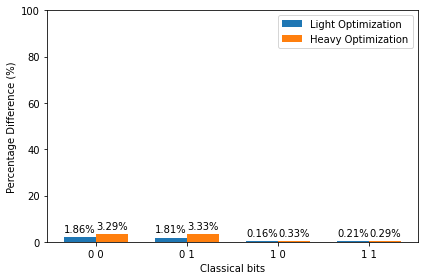

In [35]:
# plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
cbits = list(dres1.keys())
labels = cbits

values1 = list(dres1.values())
values3 = list(dres3.values())
values1 = [(i/SHOTS)*100 for i in values1]
values3 = [(i/SHOTS)*100 for i in values3]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, values1, width, label='Light Optimization')
rects2 = ax.bar(x + width / 2, values3, width, label='Heavy Optimization')

ax.set_ylabel('Percentage Difference (%)')
ax.set_xlabel('Classical bits')
# ax.set_title("Difference in measurement results between Deutsch and Bennett's protocols under light and heavy optimization levels")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# plt.grid(axis='y')
plt.ylim(0, 100)

def autolabel(rects):
   for rect in rects:
      height = rect.get_height()
      ax.annotate('{}%'.format(round(height, 2)),
         xy=(rect.get_x() + rect.get_width() / 2, height),
         xytext=(0, 3), # 3 points vertical offset
         textcoords="offset points",
         ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

In [36]:
fig.savefig("po_post_bell_pair.jpg", dpi=500)

[{'0': 2534.1, '1': 1561.8999999999999}, {'0': 3691.5, '1': 404.5}] [{'0': 2575.2999999999997, '1': 1520.7}, {'0': 3690.05, '1': 405.95}]
[{'0': 2534.1, '1': 1561.8999999999999}, {'0': 3691.5, '1': 404.5}, {'0': 2575.2999999999997, '1': 1520.7}, {'0': 3690.05, '1': 405.95}] [{'0': 2616.9500000000003, '1': 1479.0500000000002}, {'0': 3693.4500000000003, '1': 402.55}, {'0': 2723.25, '1': 1372.75}, {'0': 3688.45, '1': 407.55}]


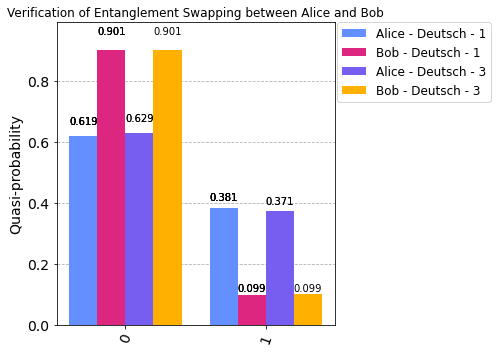

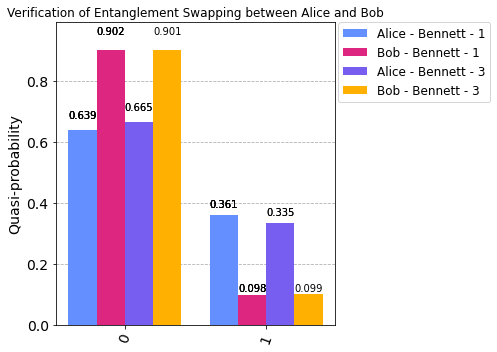

In [37]:
dqubit_counts1: list = [marginal_counts(dcounts1, [qubit]) for qubit in range(0, 2)]
dqubit_counts3: list = [marginal_counts(dcounts3, [qubit]) for qubit in range(0, 2)]

bqubit_counts1: list = [marginal_counts(bcounts1, [qubit]) for qubit in range(0, 2)]
bqubit_counts3: list = [marginal_counts(bcounts3, [qubit]) for qubit in range(0, 2)]

print(dqubit_counts1, dqubit_counts3)
dqubit_counts = dqubit_counts1 + dqubit_counts3
bqubit_counts = bqubit_counts1 + bqubit_counts3
print(dqubit_counts, bqubit_counts)

dlegend: list = ["Alice - Deutsch - 1", "Bob - Deutsch - 1", "Alice - Deutsch - 3", "Bob - Deutsch - 3"]
blegend: list = ["Alice - Bennett - 1", "Bob - Bennett - 1", "Alice - Bennett - 3", "Bob - Bennett - 3"]
d = plot_histogram(dqubit_counts, legend=dlegend,title="Verification of Entanglement Swapping between Alice and Bob")
b = plot_histogram(bqubit_counts, legend=blegend, title="Verification of Entanglement Swapping between Alice and Bob")

display(d, b)

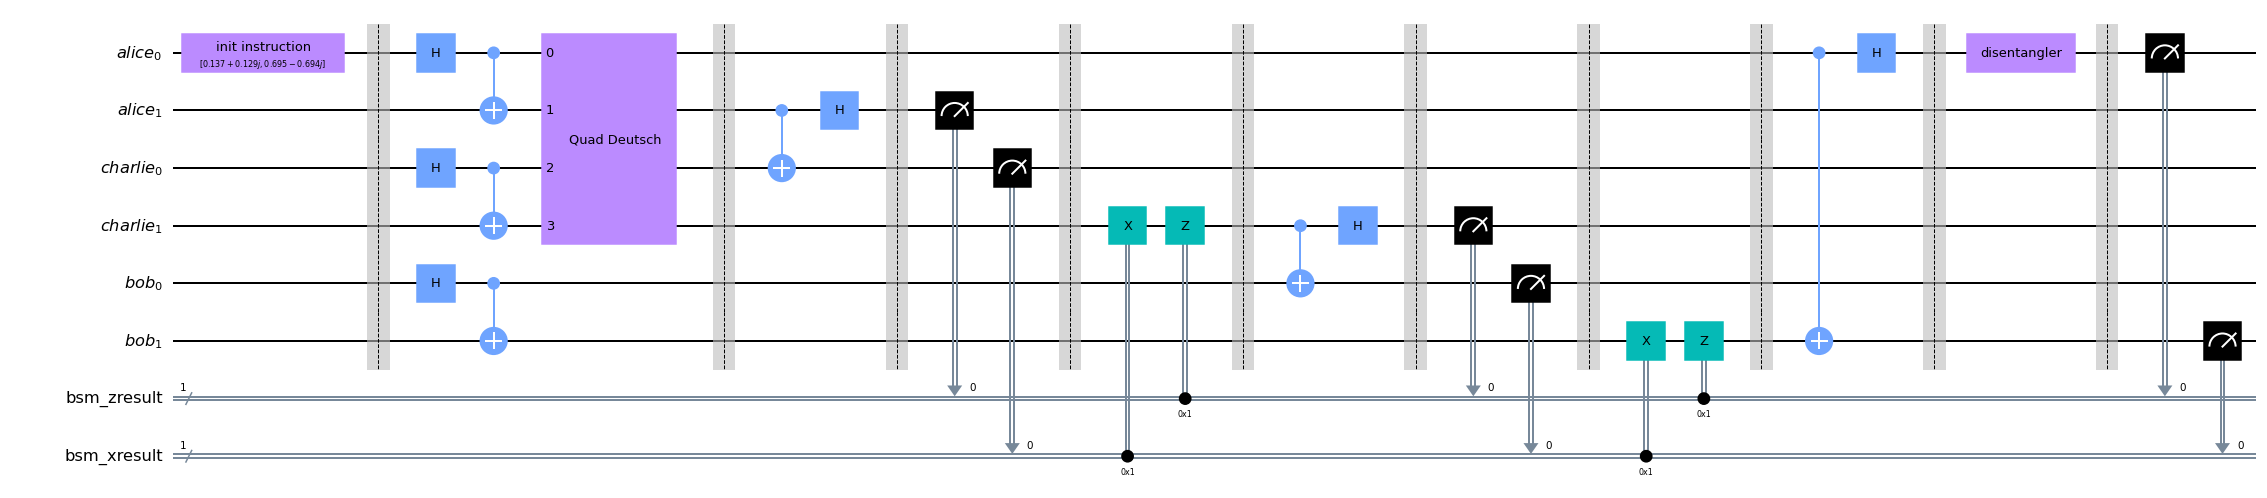

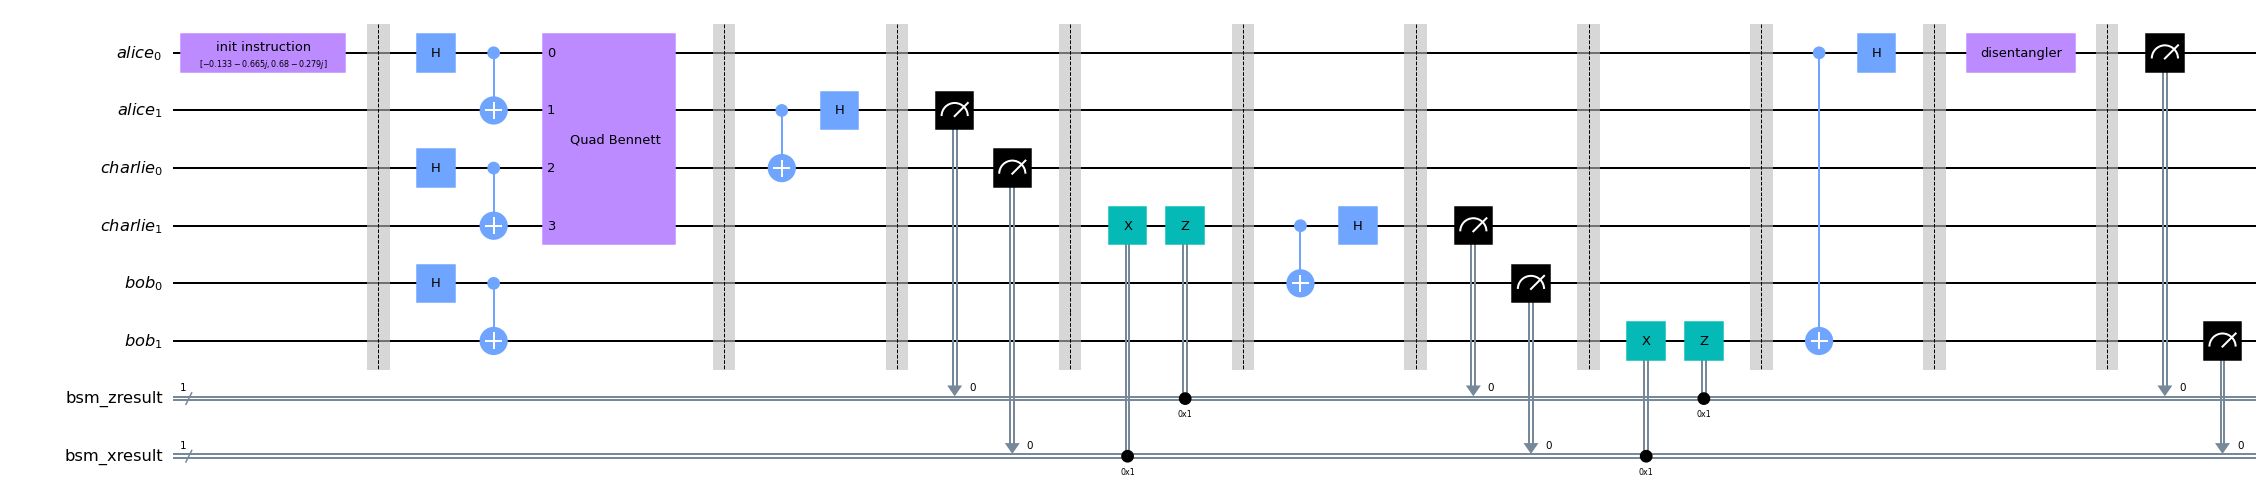

In [38]:
display(dcirc.draw("mpl", fold=-1), bcirc.draw("mpl", fold=-1))

### With Purification After Every Swap - Post swap purification

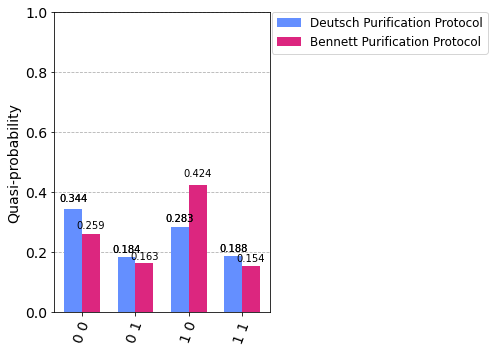

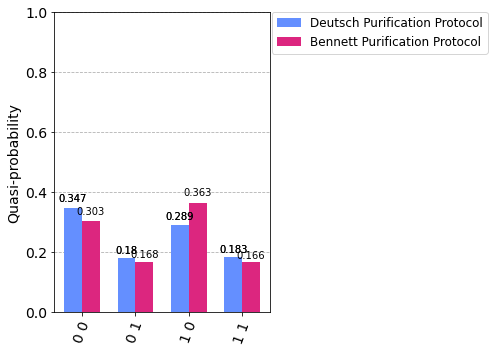

{'0 0': 1409.6, '0 1': 754.45, '1 0': 1159.9, '1 1': 772.05}
{'0 0': 1061.6, '0 1': 666.0, '1 0': 1736.1, '1 1': 632.3}
{'0 0': 348.0, '0 1': 88.45000000000005, '1 0': 576.1999999999998, '1 1': 139.75}
{'0 0': 1422.85, '0 1': 737.55, '1 0': 1184.95, '1 1': 750.65}
{'0 0': 1242.4, '0 1': 686.95, '1 0': 1486.15, '1 1': 680.5}
{'0 0': 180.44999999999982, '0 1': 50.59999999999991, '1 0': 301.20000000000005, '1 1': 70.14999999999998}


In [39]:
# circ, counts = fidelity_analysis("swap")
# # dict_counts_wp: dict = dict_counts
# dict_fids_swap: dict = get_fidelities_dict(dict_counts)
# plot_histogram(counts, title="Measurement Results of Alice and Bob's Qubits After Quantum Repeater Protocol")

d1, b1 = [], []
d3, b3 = [], []
for i in range(ITERATIONS_TO_AVG):
    dcirc, dcounts1 = deutsch_fidelity_analysis("swap", 1)
    bcirc, bcounts1 = bennett_fidelity_analysis("swap", 1)
    dcirc, dcounts3 = deutsch_fidelity_analysis("swap", 3)
    bcirc, bcounts3 = bennett_fidelity_analysis("swap", 3)
    d1.append(dcounts1)
    b1.append(bcounts1)
    d3.append(dcounts3)
    b3.append(bcounts3)

dcounts1 = dict( pd.DataFrame(d1).mean() )
bcounts1 = dict( pd.DataFrame(b1).mean() )
dcounts3 = dict( pd.DataFrame(d3).mean() )
bcounts3 = dict( pd.DataFrame(b3).mean() )

ddict_fids_swap: dict = get_fidelities_dict(dict_counts)
bdict_fids_swap: dict = get_fidelities_dict(dict_counts)

ddict_fids_swap: dict = get_fidelities_dict(dict_counts)
bdict_fids_swap: dict = get_fidelities_dict(dict_counts)

dcounts1 = dict(sorted(dcounts1.items()))
bcounts1 = dict(sorted(bcounts1.items()))
dcounts3 = dict(sorted(dcounts3.items()))
bcounts3 = dict(sorted(bcounts3.items()))

dres1 = { key: abs( dcounts1[key] - bcounts1.get(key, 0) ) for key in dcounts1.keys() }
dres3 = { key: abs( dcounts3[key] - bcounts3.get(key, 0) ) for key in dcounts3.keys() }

legend = ["Deutsch Purification Protocol", "Bennett Purification Protocol"]
d = plot_histogram([dcounts1, bcounts1], legend=legend)#, title="Testing Purification Protocols Under Light Optimization Scheme")
b = plot_histogram([dcounts3, bcounts3], legend=legend)#, title="Testing Purification Protocols Under Heavier Optimization Scheme")

dx = d.axes[0]
bx = b.axes[0]
dx.set_ylim(0, 1)
bx.set_ylim(0, 1)

display(d, b)

print(dcounts1)
print(bcounts1)
print(dres1)
print(dcounts3)
print(bcounts3)
print(dres3)

In [40]:
d.savefig("po_post_swap_light_opt_test.jpg", dpi=500)
b.savefig("po_post_swap_heavy_opt_test.jpg", dpi=500)

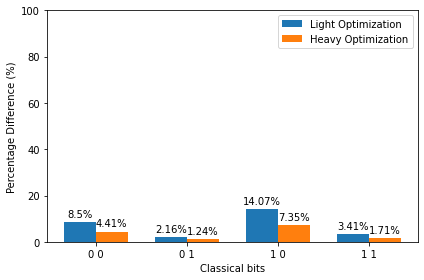

In [41]:
# plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
cbits = list(dres1.keys())
labels = cbits

values1 = list(dres1.values())
values3 = list(dres3.values())
values1 = [(i/SHOTS)*100 for i in values1]
values3 = [(i/SHOTS)*100 for i in values3]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, values1, width, label='Light Optimization')
rects2 = ax.bar(x + width / 2, values3, width, label='Heavy Optimization')

ax.set_ylabel('Percentage Difference (%)')
ax.set_xlabel('Classical bits')
# ax.set_title("Difference in measurement results between Deutsch and Bennett's protocols under light and heavy optimization levels")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# plt.grid(axis='y')
plt.ylim(0, 100)

def autolabel(rects):
   for rect in rects:
      height = rect.get_height()
      ax.annotate('{}%'.format(round(height, 2)),
         xy=(rect.get_x() + rect.get_width() / 2, height),
         xytext=(0, 3), # 3 points vertical offset
         textcoords="offset points",
         ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

In [42]:
fig.savefig("po_post_swap.jpg", dpi=500)

[{'0': 2569.5, '1': 1526.5}, {'0': 2164.05, '1': 1931.95}] [{'0': 2607.8, '1': 1488.1999999999998}, {'0': 2160.3999999999996, '1': 1935.6}]
[{'0': 2569.5, '1': 1526.5}, {'0': 2164.05, '1': 1931.95}, {'0': 2607.8, '1': 1488.1999999999998}, {'0': 2160.3999999999996, '1': 1935.6}] [{'0': 2797.7, '1': 1298.3}, {'0': 1727.6, '1': 2368.3999999999996}, {'0': 2728.55, '1': 1367.45}, {'0': 1929.3500000000001, '1': 2166.65}]


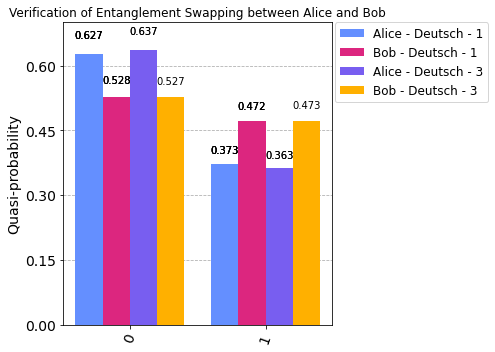

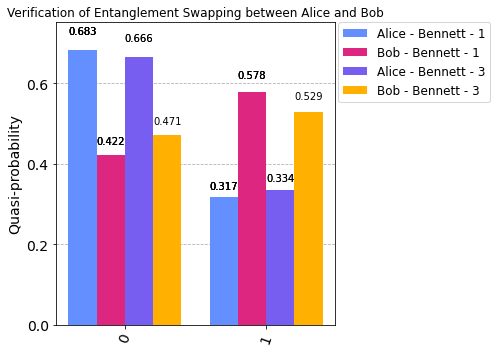

In [43]:
# qubit_counts: list = [marginal_counts(counts, [qubit]) for qubit in range(2, 4)]
# legend: list = ["alice", "bob"]
# plot_histogram(qubit_counts, legend=legend, title="Verification of Entanglement Swapping between Alice and Bob")

dqubit_counts1: list = [marginal_counts(dcounts1, [qubit]) for qubit in range(0, 2)]
dqubit_counts3: list = [marginal_counts(dcounts3, [qubit]) for qubit in range(0, 2)]

bqubit_counts1: list = [marginal_counts(bcounts1, [qubit]) for qubit in range(0, 2)]
bqubit_counts3: list = [marginal_counts(bcounts3, [qubit]) for qubit in range(0, 2)]

print(dqubit_counts1, dqubit_counts3)
dqubit_counts = dqubit_counts1 + dqubit_counts3
bqubit_counts = bqubit_counts1 + bqubit_counts3
print(dqubit_counts, bqubit_counts)

dlegend: list = ["Alice - Deutsch - 1", "Bob - Deutsch - 1", "Alice - Deutsch - 3", "Bob - Deutsch - 3"]
blegend: list = ["Alice - Bennett - 1", "Bob - Bennett - 1", "Alice - Bennett - 3", "Bob - Bennett - 3"]
d = plot_histogram(dqubit_counts, legend=dlegend,title="Verification of Entanglement Swapping between Alice and Bob")
b = plot_histogram(bqubit_counts, legend=blegend, title="Verification of Entanglement Swapping between Alice and Bob")

display(d, b)

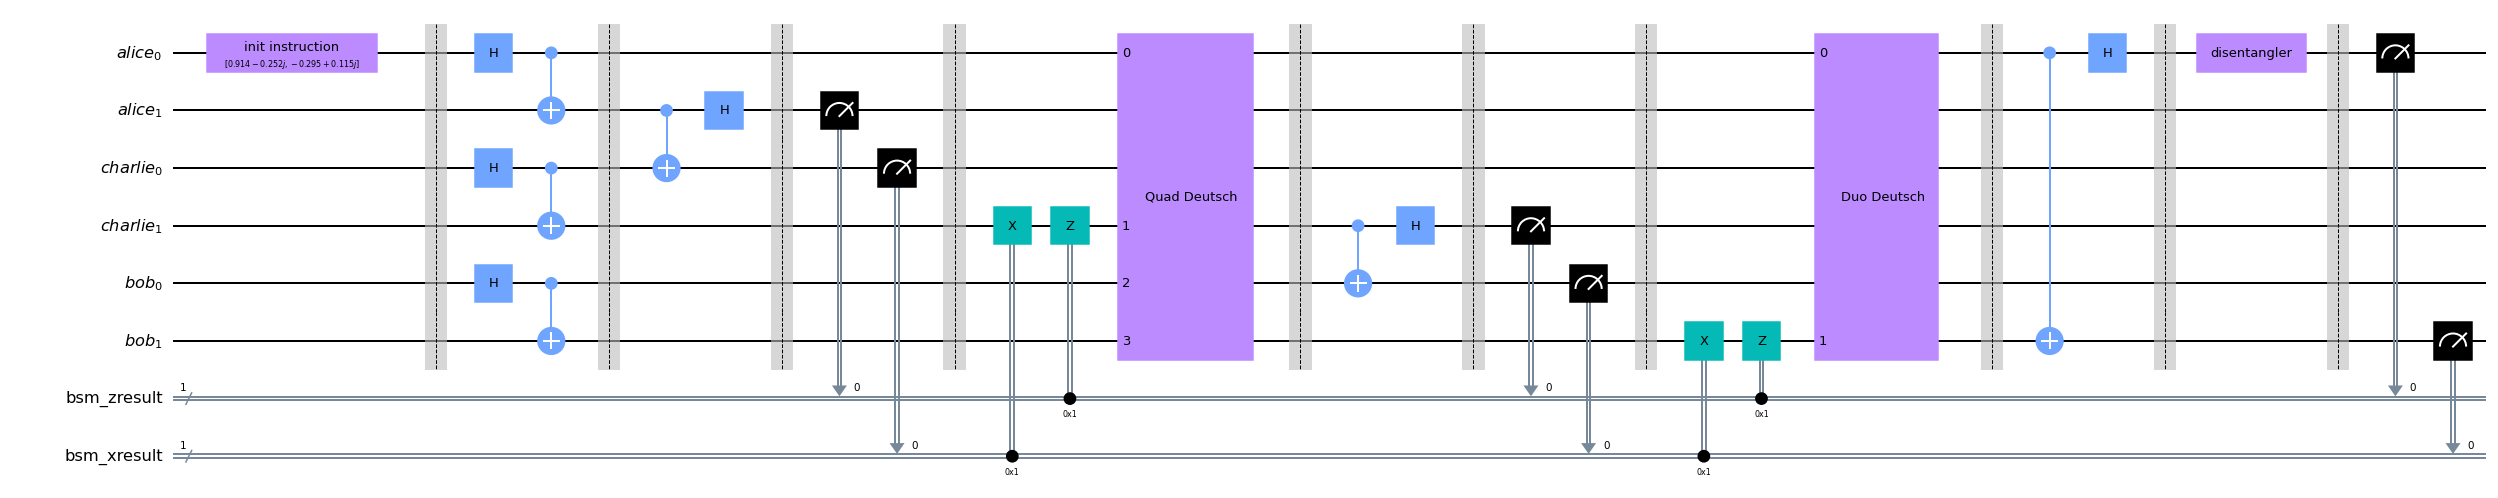

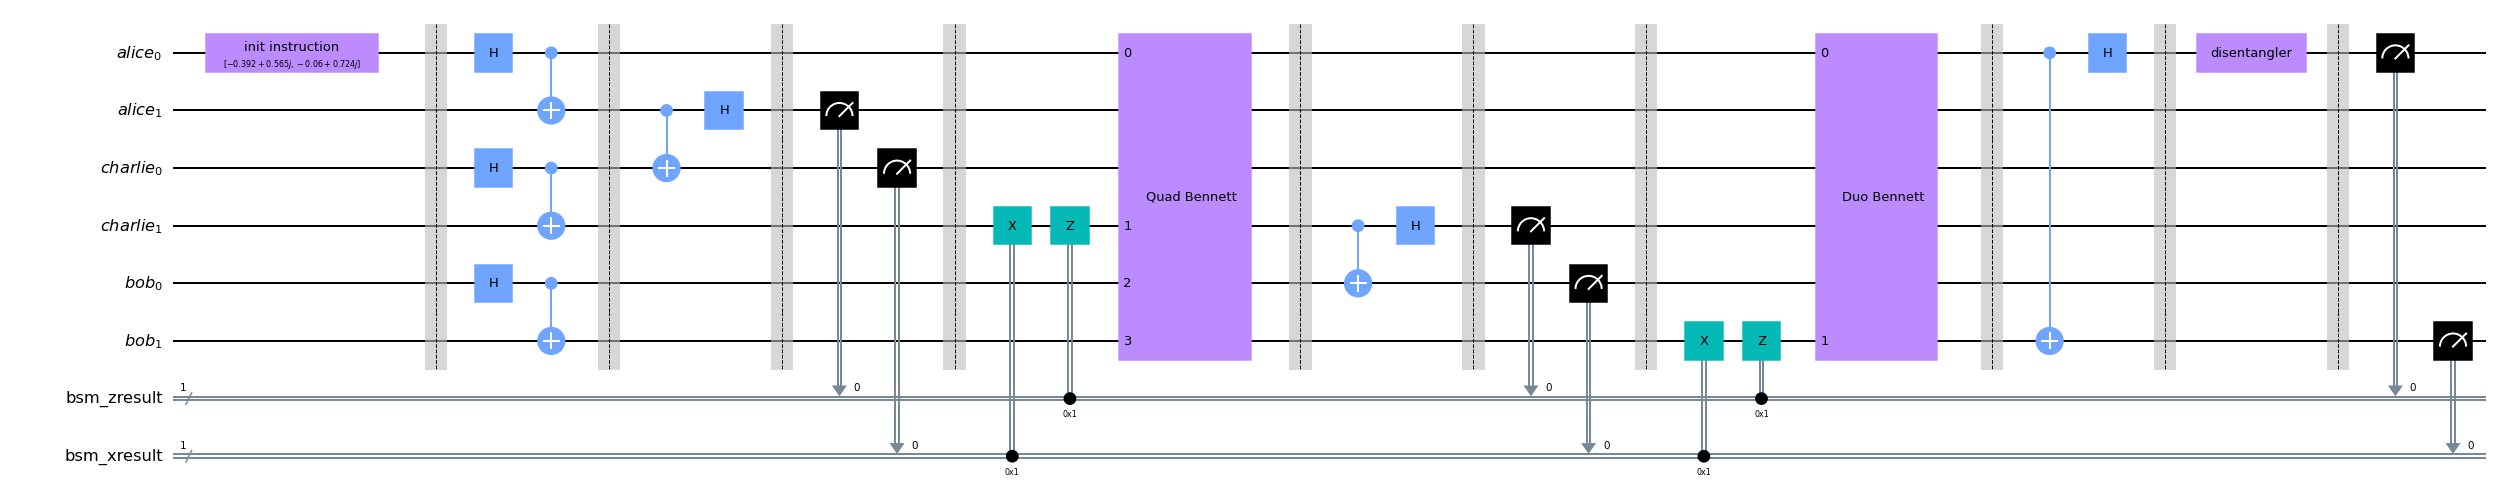

In [44]:
display( dcirc.draw("mpl", fold=-1), bcirc.draw("mpl", fold=-1) )

### With Repeated Purification After Every Swap - Repeated post swap purification

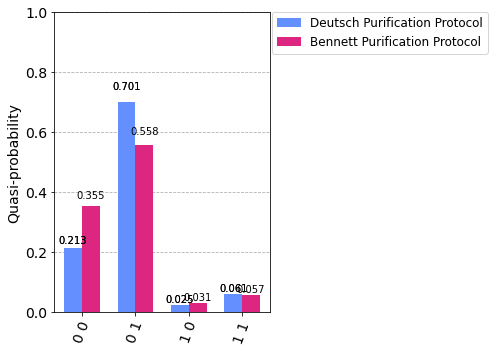

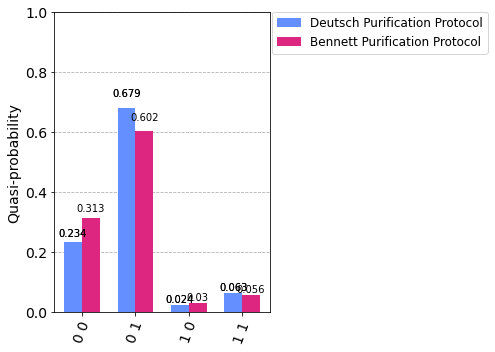

{'0 0': 872.75, '0 1': 2872.15, '1 0': 101.85, '1 1': 249.25}
{'0 0': 1452.7, '0 1': 2285.65, '1 0': 124.95, '1 1': 232.7}
{'0 0': 579.95, '0 1': 586.5, '1 0': 23.10000000000001, '1 1': 16.55000000000001}
{'0 0': 958.4, '0 1': 2783.2, '1 0': 97.85, '1 1': 256.55}
{'0 0': 1281.1, '0 1': 2464.6, '1 0': 121.65, '1 1': 228.65}
{'0 0': 322.69999999999993, '0 1': 318.5999999999999, '1 0': 23.80000000000001, '1 1': 27.900000000000006}


In [45]:
# circ, counts = fidelity_analysis("swaploop")
# # dict_counts_wp: dict = dict_counts
# dict_fids_swaploop: dict = get_fidelities_dict(dict_counts)
# plot_histogram(counts, title="Measurement Results of Alice and Bob's Qubits After Quantum Repeater Protocol")

d1, b1 = [], []
d3, b3 = [], []
for i in range(ITERATIONS_TO_AVG):
    dcirc, dcounts1 = deutsch_fidelity_analysis("swaploop", 1)
    bcirc, bcounts1 = bennett_fidelity_analysis("swaploop", 1)
    dcirc, dcounts3 = deutsch_fidelity_analysis("swaploop", 3)
    bcirc, bcounts3 = bennett_fidelity_analysis("swaploop", 3)
    d1.append(dcounts1)
    b1.append(bcounts1)
    d3.append(dcounts3)
    b3.append(bcounts3)

dcounts1 = dict( pd.DataFrame(d1).mean() )
bcounts1 = dict( pd.DataFrame(b1).mean() )
dcounts3 = dict( pd.DataFrame(d3).mean() )
bcounts3 = dict( pd.DataFrame(b3).mean() )

ddict_fids_swaploop: dict = get_fidelities_dict(dict_counts)
bdict_fids_swaploop: dict = get_fidelities_dict(dict_counts)

ddict_fids_swaploop: dict = get_fidelities_dict(dict_counts)
bdict_fids_swaploop: dict = get_fidelities_dict(dict_counts)

dcounts1 = dict(sorted(dcounts1.items()))
bcounts1 = dict(sorted(bcounts1.items()))
dcounts3 = dict(sorted(dcounts3.items()))
bcounts3 = dict(sorted(bcounts3.items()))

dres1 = { key: abs( dcounts1[key] - bcounts1.get(key, 0) ) for key in dcounts1.keys() }
dres3 = { key: abs( dcounts3[key] - bcounts3.get(key, 0) ) for key in dcounts3.keys() }

legend = ["Deutsch Purification Protocol", "Bennett Purification Protocol"]
d = plot_histogram([dcounts1, bcounts1], legend=legend)#, title="Testing Purification Protocols Under Light Optimization Scheme")
b = plot_histogram([dcounts3, bcounts3], legend=legend)#, title="Testing Purification Protocols Under Heavier Optimization Scheme")

dx = d.axes[0]
bx = b.axes[0]
dx.set_ylim(0, 1)
bx.set_ylim(0, 1)

display(d, b)

print(dcounts1)
print(bcounts1)
print(dres1)
print(dcounts3)
print(bcounts3)
print(dres3)

In [46]:
d.savefig("po_repeated_post_swap_light_opt_test.jpg", dpi=500)
b.savefig("po_repeated_post_swap_heavy_opt_test.jpg", dpi=500)

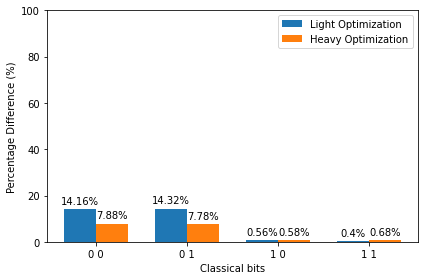

In [47]:
# plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
cbits = list(dres1.keys())
labels = cbits

values1 = list(dres1.values())
values3 = list(dres3.values())
values1 = [(i/SHOTS)*100 for i in values1]
values3 = [(i/SHOTS)*100 for i in values3]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, values1, width, label='Light Optimization')
rects2 = ax.bar(x + width / 2, values3, width, label='Heavy Optimization')

ax.set_ylabel('Percentage Difference (%)')
ax.set_xlabel('Classical bits')
# ax.set_title("Difference in measurement results between Deutsch and Bennett's protocols under light and heavy optimization levels")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# plt.grid(axis='y')
plt.ylim(0, 100)

def autolabel(rects):
   for rect in rects:
      height = rect.get_height()
      ax.annotate('{}%'.format(round(height, 2)),
         xy=(rect.get_x() + rect.get_width() / 2, height),
         xytext=(0, 3), # 3 points vertical offset
         textcoords="offset points",
         ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

In [48]:
fig.savefig("po_repeated_post_swap.jpg", dpi=500)

[{'0': 974.6, '1': 3121.4}, {'0': 3744.9, '1': 351.1}] [{'0': 1056.25, '1': 3039.75}, {'0': 3741.6, '1': 354.4}]
[{'0': 974.6, '1': 3121.4}, {'0': 3744.9, '1': 351.1}, {'0': 1056.25, '1': 3039.75}, {'0': 3741.6, '1': 354.4}] [{'0': 1577.65, '1': 2518.35}, {'0': 3738.3500000000004, '1': 357.65}, {'0': 1402.75, '1': 2693.25}, {'0': 3745.7, '1': 350.3}]


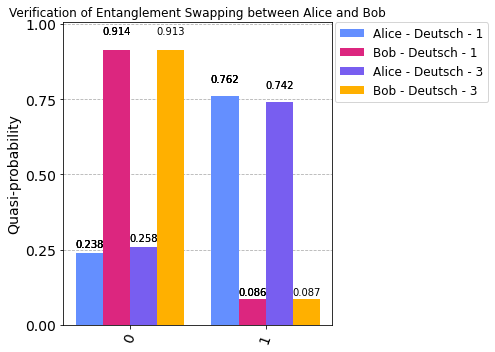

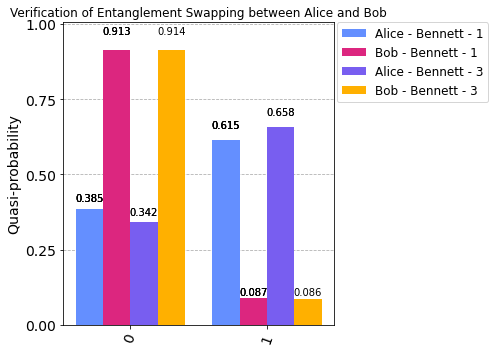

In [49]:
# qubit_counts: list = [marginal_counts(counts, [qubit]) for qubit in range(2, 4)]
# legend: list = ["alice", "bob"]
# plot_histogram(qubit_counts, legend=legend, title="Verification of Entanglement Swapping between Alice and Bob")

dqubit_counts1: list = [marginal_counts(dcounts1, [qubit]) for qubit in range(0, 2)]
dqubit_counts3: list = [marginal_counts(dcounts3, [qubit]) for qubit in range(0, 2)]

bqubit_counts1: list = [marginal_counts(bcounts1, [qubit]) for qubit in range(0, 2)]
bqubit_counts3: list = [marginal_counts(bcounts3, [qubit]) for qubit in range(0, 2)]

print(dqubit_counts1, dqubit_counts3)
dqubit_counts = dqubit_counts1 + dqubit_counts3
bqubit_counts = bqubit_counts1 + bqubit_counts3
print(dqubit_counts, bqubit_counts)

dlegend: list = ["Alice - Deutsch - 1", "Bob - Deutsch - 1", "Alice - Deutsch - 3", "Bob - Deutsch - 3"]
blegend: list = ["Alice - Bennett - 1", "Bob - Bennett - 1", "Alice - Bennett - 3", "Bob - Bennett - 3"]
d = plot_histogram(dqubit_counts, legend=dlegend,title="Verification of Entanglement Swapping between Alice and Bob")
b = plot_histogram(bqubit_counts, legend=blegend, title="Verification of Entanglement Swapping between Alice and Bob")

display(d, b)

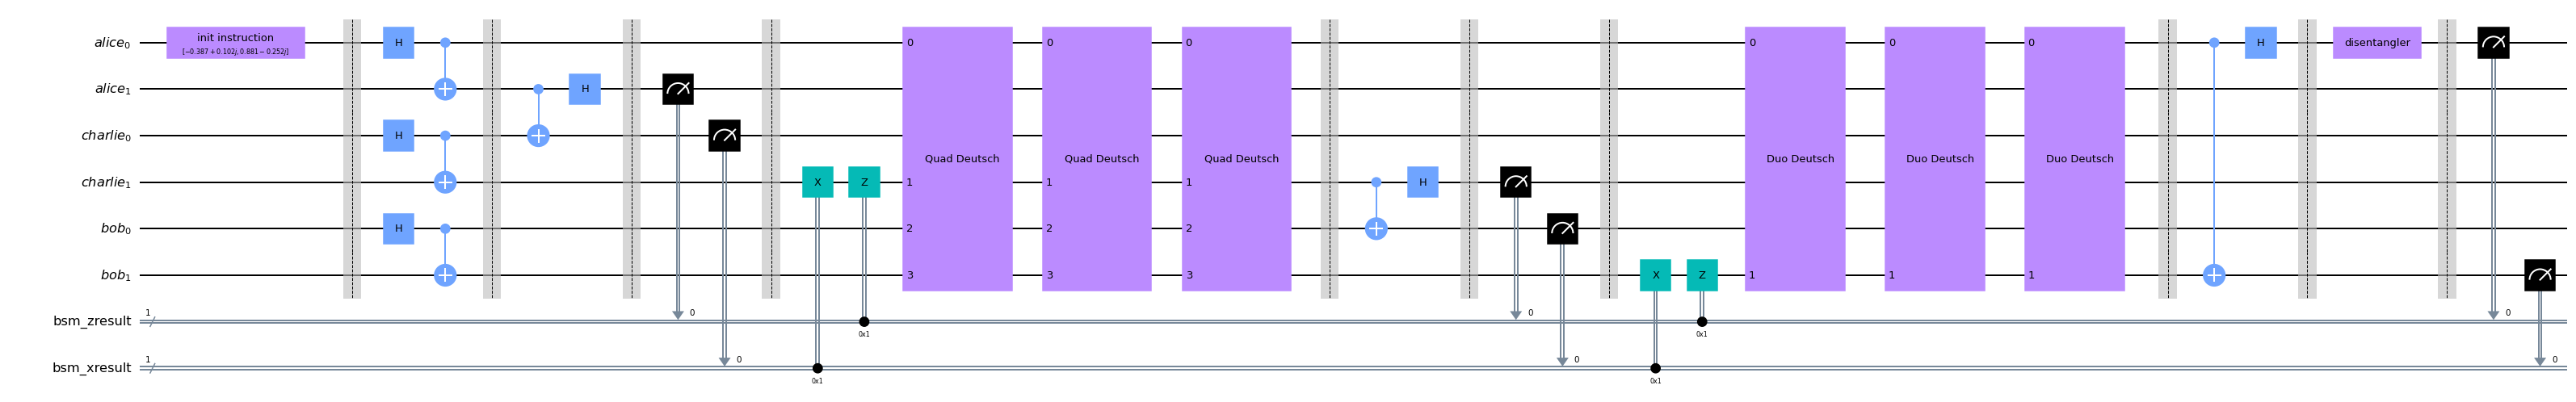

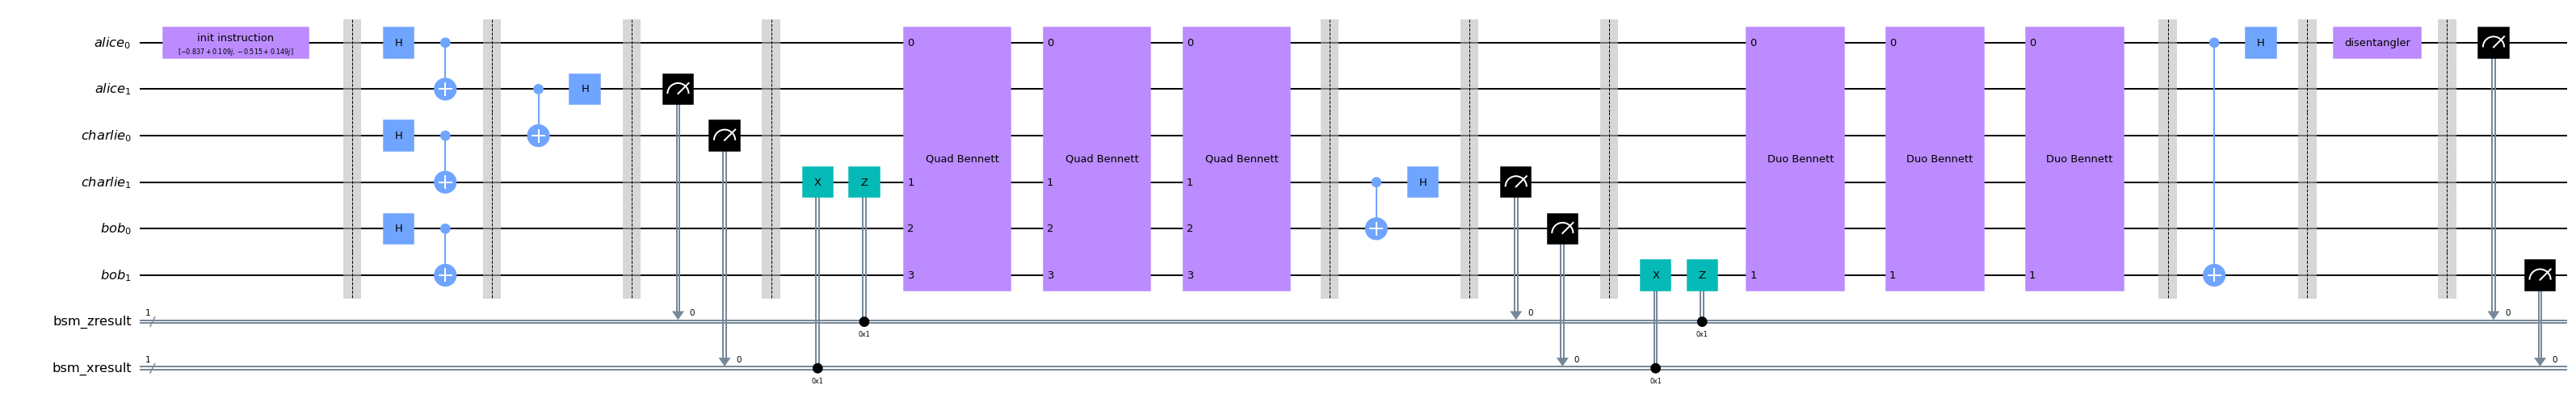

In [50]:
display(dcirc.draw("mpl", fold=-1), bcirc.draw("mpl", fold=-1) )

### With Purification Before and After Every Swap - Pre and Post swap purification

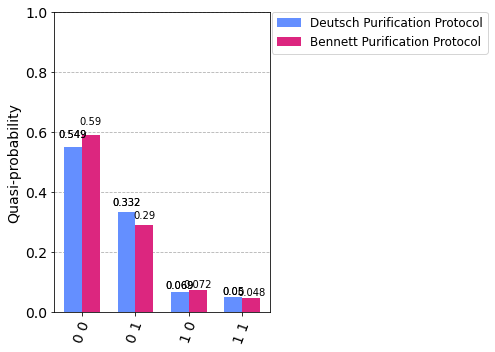

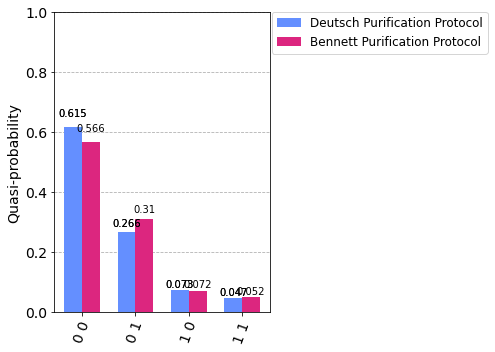

{'0 0': 2248.45, '0 1': 1360.15, '1 0': 280.6, '1 1': 206.8}
{'0 0': 2417.85, '0 1': 1187.15, '1 0': 295.7, '1 1': 195.3}
{'0 0': 169.4000000000001, '0 1': 173.0, '1 0': 15.099999999999966, '1 1': 11.5}
{'0 0': 2519.85, '0 1': 1087.7, '1 0': 297.65, '1 1': 190.8}
{'0 0': 2320.15, '0 1': 1271.5, '1 0': 293.15, '1 1': 211.2}
{'0 0': 199.69999999999982, '0 1': 183.79999999999995, '1 0': 4.5, '1 1': 20.399999999999977}


In [51]:
# circ, counts = fidelity_analysis("swapalt")
# # dict_counts_wp: dict = dict_counts
# dict_fids_swapalt: dict = get_fidelities_dict(dict_counts)
# plot_histogram(counts, title="Measurement Results of Alice and Bob's Qubits After Quantum Repeater Protocol")

d1, b1 = [], []
d3, b3 = [], []
for i in range(ITERATIONS_TO_AVG):
    dcirc, dcounts1 = deutsch_fidelity_analysis("swapalt", 1)
    bcirc, bcounts1 = bennett_fidelity_analysis("swapalt", 1)
    dcirc, dcounts3 = deutsch_fidelity_analysis("swapalt", 3)
    bcirc, bcounts3 = bennett_fidelity_analysis("swapalt", 3)
    d1.append(dcounts1)
    b1.append(bcounts1)
    d3.append(dcounts3)
    b3.append(bcounts3)

dcounts1 = dict( pd.DataFrame(d1).mean() )
bcounts1 = dict( pd.DataFrame(b1).mean() )
dcounts3 = dict( pd.DataFrame(d3).mean() )
bcounts3 = dict( pd.DataFrame(b3).mean() )

ddict_fids_swapalt: dict = get_fidelities_dict(dict_counts)
bdict_fids_swapalt: dict = get_fidelities_dict(dict_counts)

ddict_fids_swapalt: dict = get_fidelities_dict(dict_counts)
bdict_fids_swapalt: dict = get_fidelities_dict(dict_counts)

dcounts1 = dict(sorted(dcounts1.items()))
bcounts1 = dict(sorted(bcounts1.items()))
dcounts3 = dict(sorted(dcounts3.items()))
bcounts3 = dict(sorted(bcounts3.items()))

dres1 = { key: abs( dcounts1[key] - bcounts1.get(key, 0) ) for key in dcounts1.keys() }
dres3 = { key: abs( dcounts3[key] - bcounts3.get(key, 0) ) for key in dcounts3.keys() }

legend = ["Deutsch Purification Protocol", "Bennett Purification Protocol"]
d = plot_histogram([dcounts1, bcounts1], legend=legend)#, title="Testing Purification Protocols Under Light Optimization Scheme")
b = plot_histogram([dcounts3, bcounts3], legend=legend)#, title="Testing Purification Protocols Under Heavier Optimization Scheme")

dx = d.axes[0]
bx = b.axes[0]
dx.set_ylim(0, 1)
bx.set_ylim(0, 1)

display(d, b)

print(dcounts1)
print(bcounts1)
print(dres1)
print(dcounts3)
print(bcounts3)
print(dres3)

In [52]:
d.savefig("po_pre_and_post_swap_light_opt_test.jpg", dpi=500)
b.savefig("po_pre_and_post_swap_heavy_opt_test.jpg", dpi=500)

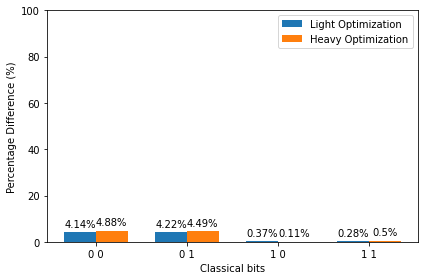

In [53]:
# plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
cbits = list(dres1.keys())
labels = cbits

values1 = list(dres1.values())
values3 = list(dres3.values())
values1 = [i*100/SHOTS for i in values1]
values3 = [i*100/SHOTS for i in values3]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, values1, width, label='Light Optimization')
rects2 = ax.bar(x + width / 2, values3, width, label='Heavy Optimization')

ax.set_ylabel('Percentage Difference (%)')
ax.set_xlabel('Classical bits')
# ax.set_title("Difference in measurement results between Deutsch and Bennett's protocols under light and heavy optimization levels")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# plt.grid(axis='y')
plt.ylim(0, 100)

def autolabel(rects):
   for rect in rects:
      height = rect.get_height()
      ax.annotate('{}%'.format(round(height, 2)),
         xy=(rect.get_x() + rect.get_width() / 2, height),
         xytext=(0, 3), # 3 points vertical offset
         textcoords="offset points",
         ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

In [54]:
fig.savefig("po_pre_and_post_swap.jpg", dpi=500)

[{'0': 2529.0499999999997, '1': 1566.95}, {'0': 3608.6, '1': 487.40000000000003}] [{'0': 2817.5, '1': 1278.5}, {'0': 3607.55, '1': 488.45}]
[{'0': 2529.0499999999997, '1': 1566.95}, {'0': 3608.6, '1': 487.40000000000003}, {'0': 2817.5, '1': 1278.5}, {'0': 3607.55, '1': 488.45}] [{'0': 2713.5499999999997, '1': 1382.45}, {'0': 3605.0, '1': 491.0}, {'0': 2613.3, '1': 1482.7}, {'0': 3591.65, '1': 504.34999999999997}]


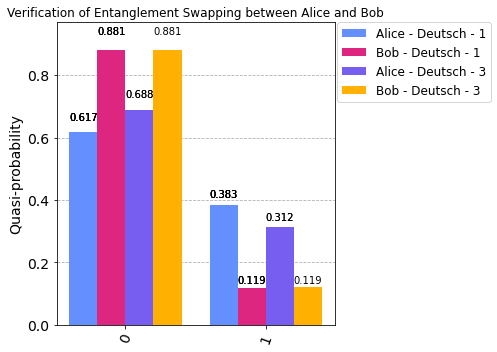

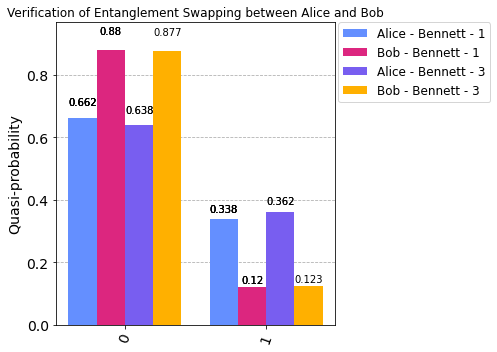

In [55]:
# qubit_counts: list = [marginal_counts(counts, [qubit]) for qubit in range(2, 4)]
# legend: list = ["alice", "bob"]
# plot_histogram(qubit_counts, legend=legend, title="Verification of Entanglement Swapping between Alice and Bob")

dqubit_counts1: list = [marginal_counts(dcounts1, [qubit]) for qubit in range(0, 2)]
dqubit_counts3: list = [marginal_counts(dcounts3, [qubit]) for qubit in range(0, 2)]

bqubit_counts1: list = [marginal_counts(bcounts1, [qubit]) for qubit in range(0, 2)]
bqubit_counts3: list = [marginal_counts(bcounts3, [qubit]) for qubit in range(0, 2)]

print(dqubit_counts1, dqubit_counts3)
dqubit_counts = dqubit_counts1 + dqubit_counts3
bqubit_counts = bqubit_counts1 + bqubit_counts3
print(dqubit_counts, bqubit_counts)

dlegend: list = ["Alice - Deutsch - 1", "Bob - Deutsch - 1", "Alice - Deutsch - 3", "Bob - Deutsch - 3"]
blegend: list = ["Alice - Bennett - 1", "Bob - Bennett - 1", "Alice - Bennett - 3", "Bob - Bennett - 3"]
d = plot_histogram(dqubit_counts, legend=dlegend,title="Verification of Entanglement Swapping between Alice and Bob")
b = plot_histogram(bqubit_counts, legend=blegend, title="Verification of Entanglement Swapping between Alice and Bob")

display(d, b)

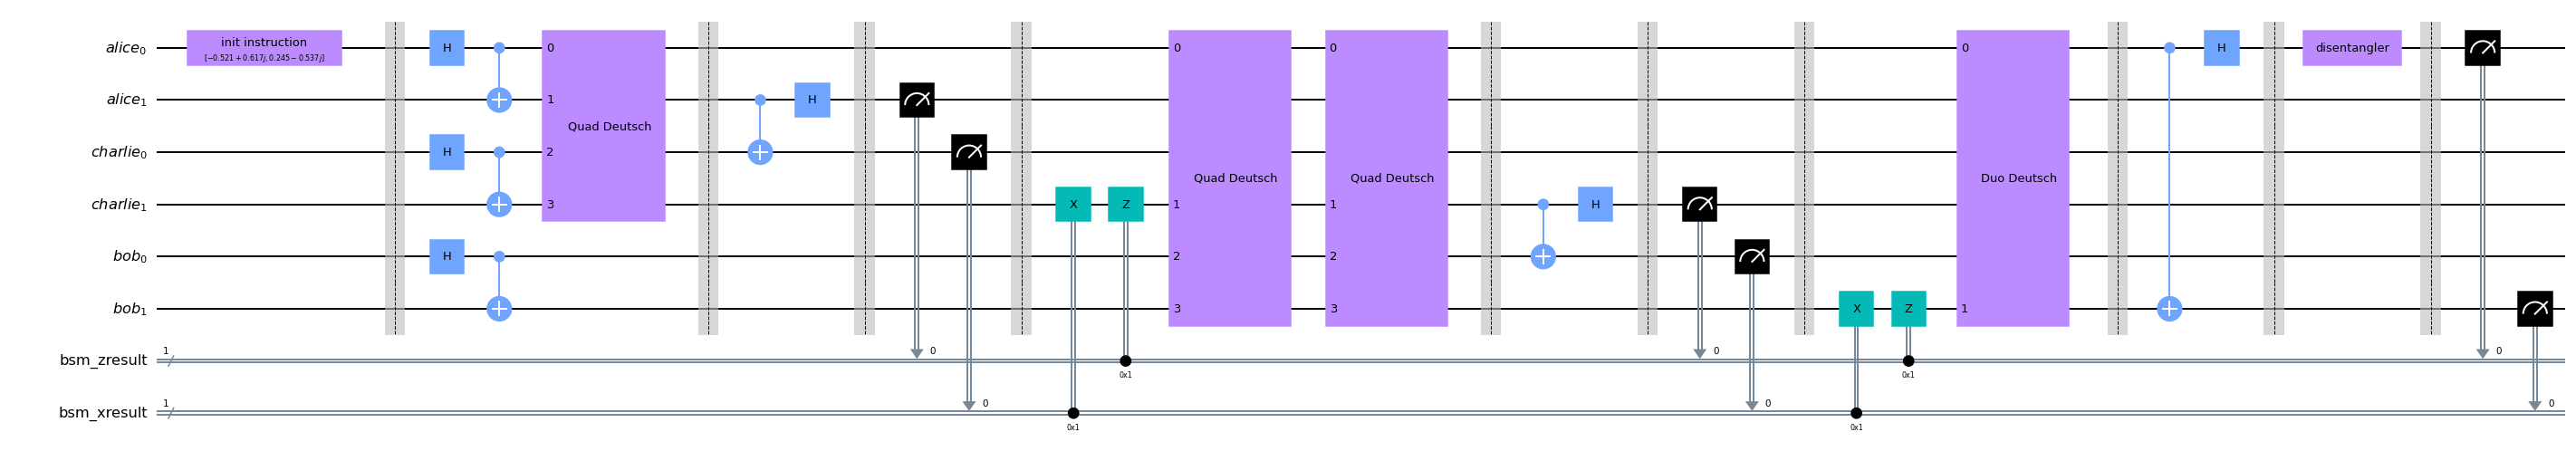

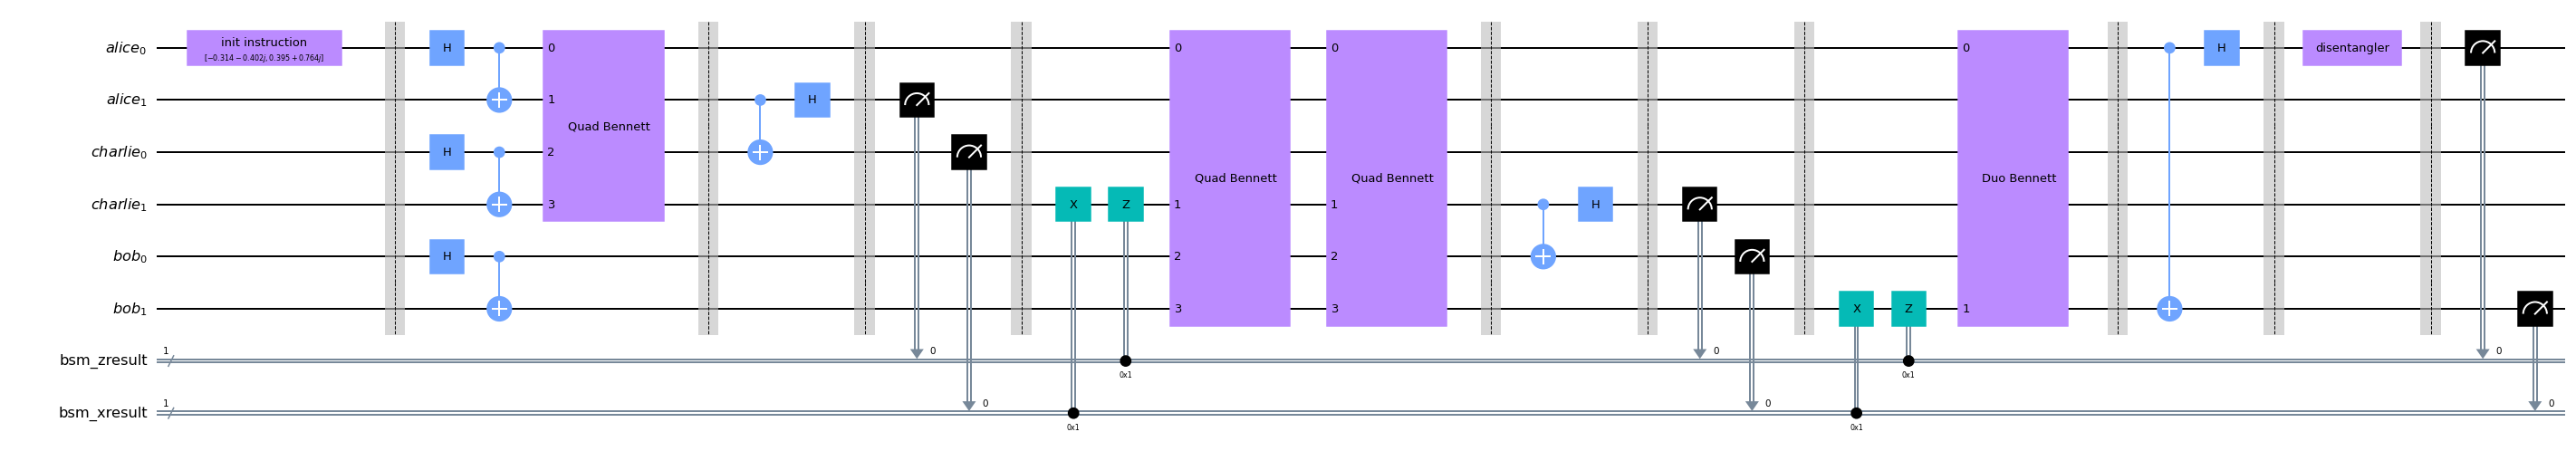

In [56]:
display( dcirc.draw("mpl", fold=-1), bcirc.draw("mpl", fold=-1) )